# Дерево решений (Decision Tree)

---

**Источники:**

[Decision tree](https://en.wikipedia.org/wiki/Decision_tree#:~:text=A%20decision%20tree%20is%20a,only%20contains%20conditional%20control%20statements.)

[Дерево решений](https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D1%80%D0%B5%D0%B2%D0%BE_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B9)

[Decision Tree vs Random Forest](https://mljar.com/machine-learning/decision-tree-vs-random-forest/)

[Decision Trees and Random Forest Tutorial](https://www.kaggle.com/getting-started/131902)

[1.10. Decision Trees](https://scikit-learn.org/stable/modules/tree.html)

[Decision Tree Classification Algorithm](https://www.javatpoint.com/machine-learning-decision-tree-classification-algorithm)

[The Complete Guide to Decision Trees](https://www.explorium.ai/blog/the-complete-guide-to-decision-trees/)

[1 How to visualize decision trees](https://explained.ai/decision-tree-viz/index.html)

[Что такое дерево решений и где его используют?](https://habr.com/ru/company/productstar/blog/523044/)

---

## Подготовка окружения

In [1]:
# ВНИМАНИЕ: необходимо удостовериться, что виртуальная среда выбрана правильно!

# Для MacOS/Ubuntu
# !which pip

# Для Windows
# !where pip

In [2]:
# !conda install matplotlib numpy scikit-learn seaborn -y

In [3]:
# !conda install -c conda-forge pydotplus python-graphviz -y

In [4]:
import numpy as np

np.__version__

'1.19.2'

In [5]:
import pandas as pd

pd.__version__

'1.2.3'

In [6]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.__version__

'3.3.4'

In [7]:
import seaborn as sns

sns.__version__

'0.11.1'

In [8]:
import sklearn

sklearn.__version__

'0.24.1'

In [9]:
from pydotplus import version as pydotplus_version

pydotplus_version.__version__

'2.0.2'

In [10]:
import graphviz

graphviz.__version__

'0.16'

## Загрузка данных

[Источник (drug200)](https://www.kaggle.com/jeevanrh/drug200csv).

In [11]:
df = pd.read_csv('./../../data/drug200.csv')

# показать все колонки
pd.options.display.max_columns = None

# изменить формат отображения с помощью средства форматирования
# (float без E, а 2 знаков после запятой)
# (для удобства чтения)
pd.options.display.float_format = '{:.2f}'.format

# отобразить первые 5 и последние 5 строк
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.36,drugY
1,47,M,LOW,HIGH,13.09,drugC
2,47,M,LOW,HIGH,10.11,drugC
3,28,F,NORMAL,HIGH,7.80,drugX
4,61,F,LOW,HIGH,18.04,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.57,drugC
196,16,M,LOW,HIGH,12.01,drugC
197,52,M,NORMAL,HIGH,9.89,drugX
198,23,M,NORMAL,NORMAL,14.02,drugX


### Предварительная обработка (pre-processing) и выбор (selection) данных

In [12]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder(categories=[['LOW', 'NORMAL', 'HIGH'], ['NORMAL', 'HIGH']])
df[['BP_enc', 'Cholesterol_enc']]  = ord_enc.fit_transform(df[['BP', 'Cholesterol']])
df[['BP', 'BP_enc', 'Cholesterol', 'Cholesterol_enc']]

,BP,BP_enc,Cholesterol,Cholesterol_enc
0,HIGH,2.00,HIGH,1.00
1,LOW,0.00,HIGH,1.00
2,LOW,0.00,HIGH,1.00
3,NORMAL,1.00,HIGH,1.00
4,LOW,0.00,HIGH,1.00
...,...,...,...,...
195,LOW,0.00,HIGH,1.00
196,LOW,0.00,HIGH,1.00
197,NORMAL,1.00,HIGH,1.00
198,NORMAL,1.00,NORMAL,0.00


In [13]:
from sklearn.preprocessing import OneHotEncoder

oh_enc = OneHotEncoder(sparse=False)
oh_result = oh_enc.fit_transform(df[['Sex']])
columns = oh_enc.get_feature_names(['Sex'])
oh_enc_df = pd.DataFrame(oh_result, columns=columns)
df = df.join(oh_enc_df)
df[['Sex'] + columns.tolist()]

,Sex,Sex_F,Sex_M
0,F,1.00,0.00
1,M,0.00,1.00
2,M,0.00,1.00
3,F,1.00,0.00
4,F,1.00,0.00
...,...,...,...
195,F,1.00,0.00
196,M,0.00,1.00
197,M,0.00,1.00
198,M,0.00,1.00


In [14]:
X = df[['Age', 'BP_enc', 'Cholesterol_enc', 'Na_to_K'] + columns.tolist()]
X

,Age,BP_enc,Cholesterol_enc,Na_to_K,Sex_F,Sex_M
0,23,2.00,1.00,25.36,1.00,0.00
1,47,0.00,1.00,13.09,0.00,1.00
2,47,0.00,1.00,10.11,0.00,1.00
3,28,1.00,1.00,7.80,1.00,0.00
4,61,0.00,1.00,18.04,1.00,0.00
...,...,...,...,...,...,...
195,56,0.00,1.00,11.57,1.00,0.00
196,16,0.00,1.00,12.01,0.00,1.00
197,52,1.00,1.00,9.89,0.00,1.00
198,23,1.00,0.00,14.02,0.00,1.00


In [15]:
y = df["Drug"]
y[0:5]

0    drugY
1    drugC
2    drugC
3    drugX
4    drugY
Name: Drug, dtype: object

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3)

print('Shape of X training set {}'.format(X_train.shape),'&',' Size of y training set {}'.format(y_train.shape))

Shape of X training set (140, 6) &  Size of y training set (140,)


## Дерево решений (Decision Tree)

Дерево принятия решений (также называют деревом классификации или регрессионным деревом).

<img src="images/tree_titanic_survivors.png" width=400 height=400/>

<img src="images/dtree.gif" width=800 height=800/>

Структура дерева представляет собой "листья" и "ветки". На рёбрах ("ветках") дерева решения записаны признаки, от которых зависит целевая функция, в "листьях" записаны значения целевой функции, а в остальных узлах — признаки, по которым различаются случаи. Чтобы классифицировать новый случай, надо спуститься по дереву до листа и выдать соответствующее значение.

Деревья решений бывают двух основных типов:
- Дерево для классификации, когда предсказываемый результат является классом, к которому принадлежат данные;
- Дерево для регрессии, когда предсказываемый результат можно рассматривать как вещественное число (например, цена на дом, или продолжительность пребывания пациента в больнице).

Некоторые методы позволяют построить более одного дерева решений (ансамбли деревьев решений).

Существуют различные способы выбирать очередной признак. В результате работы этих алгоритмов часто получаются слишком подробные деревья, которые при их дальнейшем применении дают много ошибок. Это связано с явлением переобучения. **Для сокращения деревьев используют отсечение ветвей (pruning).**

### Достоинства

- Прост в понимании и интерпретации.
- Легко визуализируются, то есть могут «интерпретироваться» не только как модель в целом, но и как прогноз для отдельного тестового субъекта (путь в дереве).
- Способен генерировать правила в областях, где специалисту трудно формализовать свои знания.
- Не требует специальной подготовки данных, как например: нормализации данных, добавления фиктивных переменных, а также удаления пропущенных данных.
- Способен работать как с категориальными, так и с интервальными переменными. Прочие методы работают лишь с теми данными, где присутствует лишь один тип переменных.
- Использует модель "белого ящика", т.е. если определённая ситуация наблюдается в модели, то её **можно объяснить при помощи булевой логики**. Примером "черного ящика" может быть искусственная нейронная сеть, так как полученные результаты сложно объяснить.
- Позволяет работать с большим объёмом информации без специальных подготовительных процедур.

### Недостатки

- Деревья решений чувствительны к шумам во входных данных. Небольшие изменения обучающей выборки могут привести к глобальным корректировкам модели, что скажется на смене правил классификации и интерпретируемости модели.
- Проблема получения оптимального дерева решений является [NP-полной задачей](https://ru.wikipedia.org/wiki/NP-%D0%BF%D0%BE%D0%BB%D0%BD%D0%B0%D1%8F_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0), с точки зрения некоторых аспектов оптимальности даже для простых задач. Таким образом, практическое применение алгоритма деревьев решений основано на эвристических алгоритмах, таких как алгоритм "жадности", где единственно оптимальное решение выбирается локально в каждом узле. Такие алгоритмы не могут обеспечить оптимальность всего дерева в целом.
- В процессе построения дерева решений могут создаваться слишком сложные конструкции, которые недостаточно полно представляют данные. Данную проблему называют переобучением. Для того, чтобы её избежать, необходимо использовать метод «регулирования глубины дерева».
    - Регулирование глубины дерева — это техника, которая позволяет уменьшать размер дерева решений, удаляя участки дерева, которые имеют маленький вес.
    - Один из вопросов, который возникает в алгоритме дерева решений — это оптимальный размер конечного дерева.
    - Так, небольшое дерево может не охватить ту или иную важную информацию о выборочном пространстве.
    - Трудно сказать, когда алгоритм должен остановиться, потому что невозможно спрогнозировать, добавление какого узла позволит значительно уменьшить ошибку. 
    - Важно помнить, что регулирование глубины дерева должно уменьшить размер обучающей модели дерева без уменьшения точности её прогноза или с помощью перекрестной проверки.
    - Есть много методов регулирования глубины дерева, которые отличаются измерением оптимизации производительности.
- Существуют понятия, которые сложно понять из модели, так как модель описывает их сложным путём. В этом случае имеем дело с непомерно большими деревьями.

## Обучение модели (Train)

In [17]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
model

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [18]:
model.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [19]:
y_predicted = model.predict(X_test)

In [20]:
print (y_predicted [0:5])
print (y_test [0:5])

['drugX' 'drugY' 'drugY' 'drugX' 'drugY']
106    drugX
91     drugY
53     drugY
139    drugX
87     drugY
Name: Drug, dtype: object


## Оценка качества модели (Evaluation)

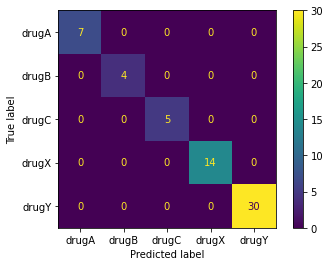

In [21]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_test, y_test)

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

       drugA       1.00      1.00      1.00         7
       drugB       1.00      1.00      1.00         4
       drugC       1.00      1.00      1.00         5
       drugX       1.00      1.00      1.00        14
       drugY       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [23]:
from sklearn.metrics import f1_score
f1_score(y_test, y_predicted, average='weighted') 

1.0

In [24]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, y_predicted))

DecisionTrees's Accuracy:  1.0


## Визуализация (Visualization)

In [25]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

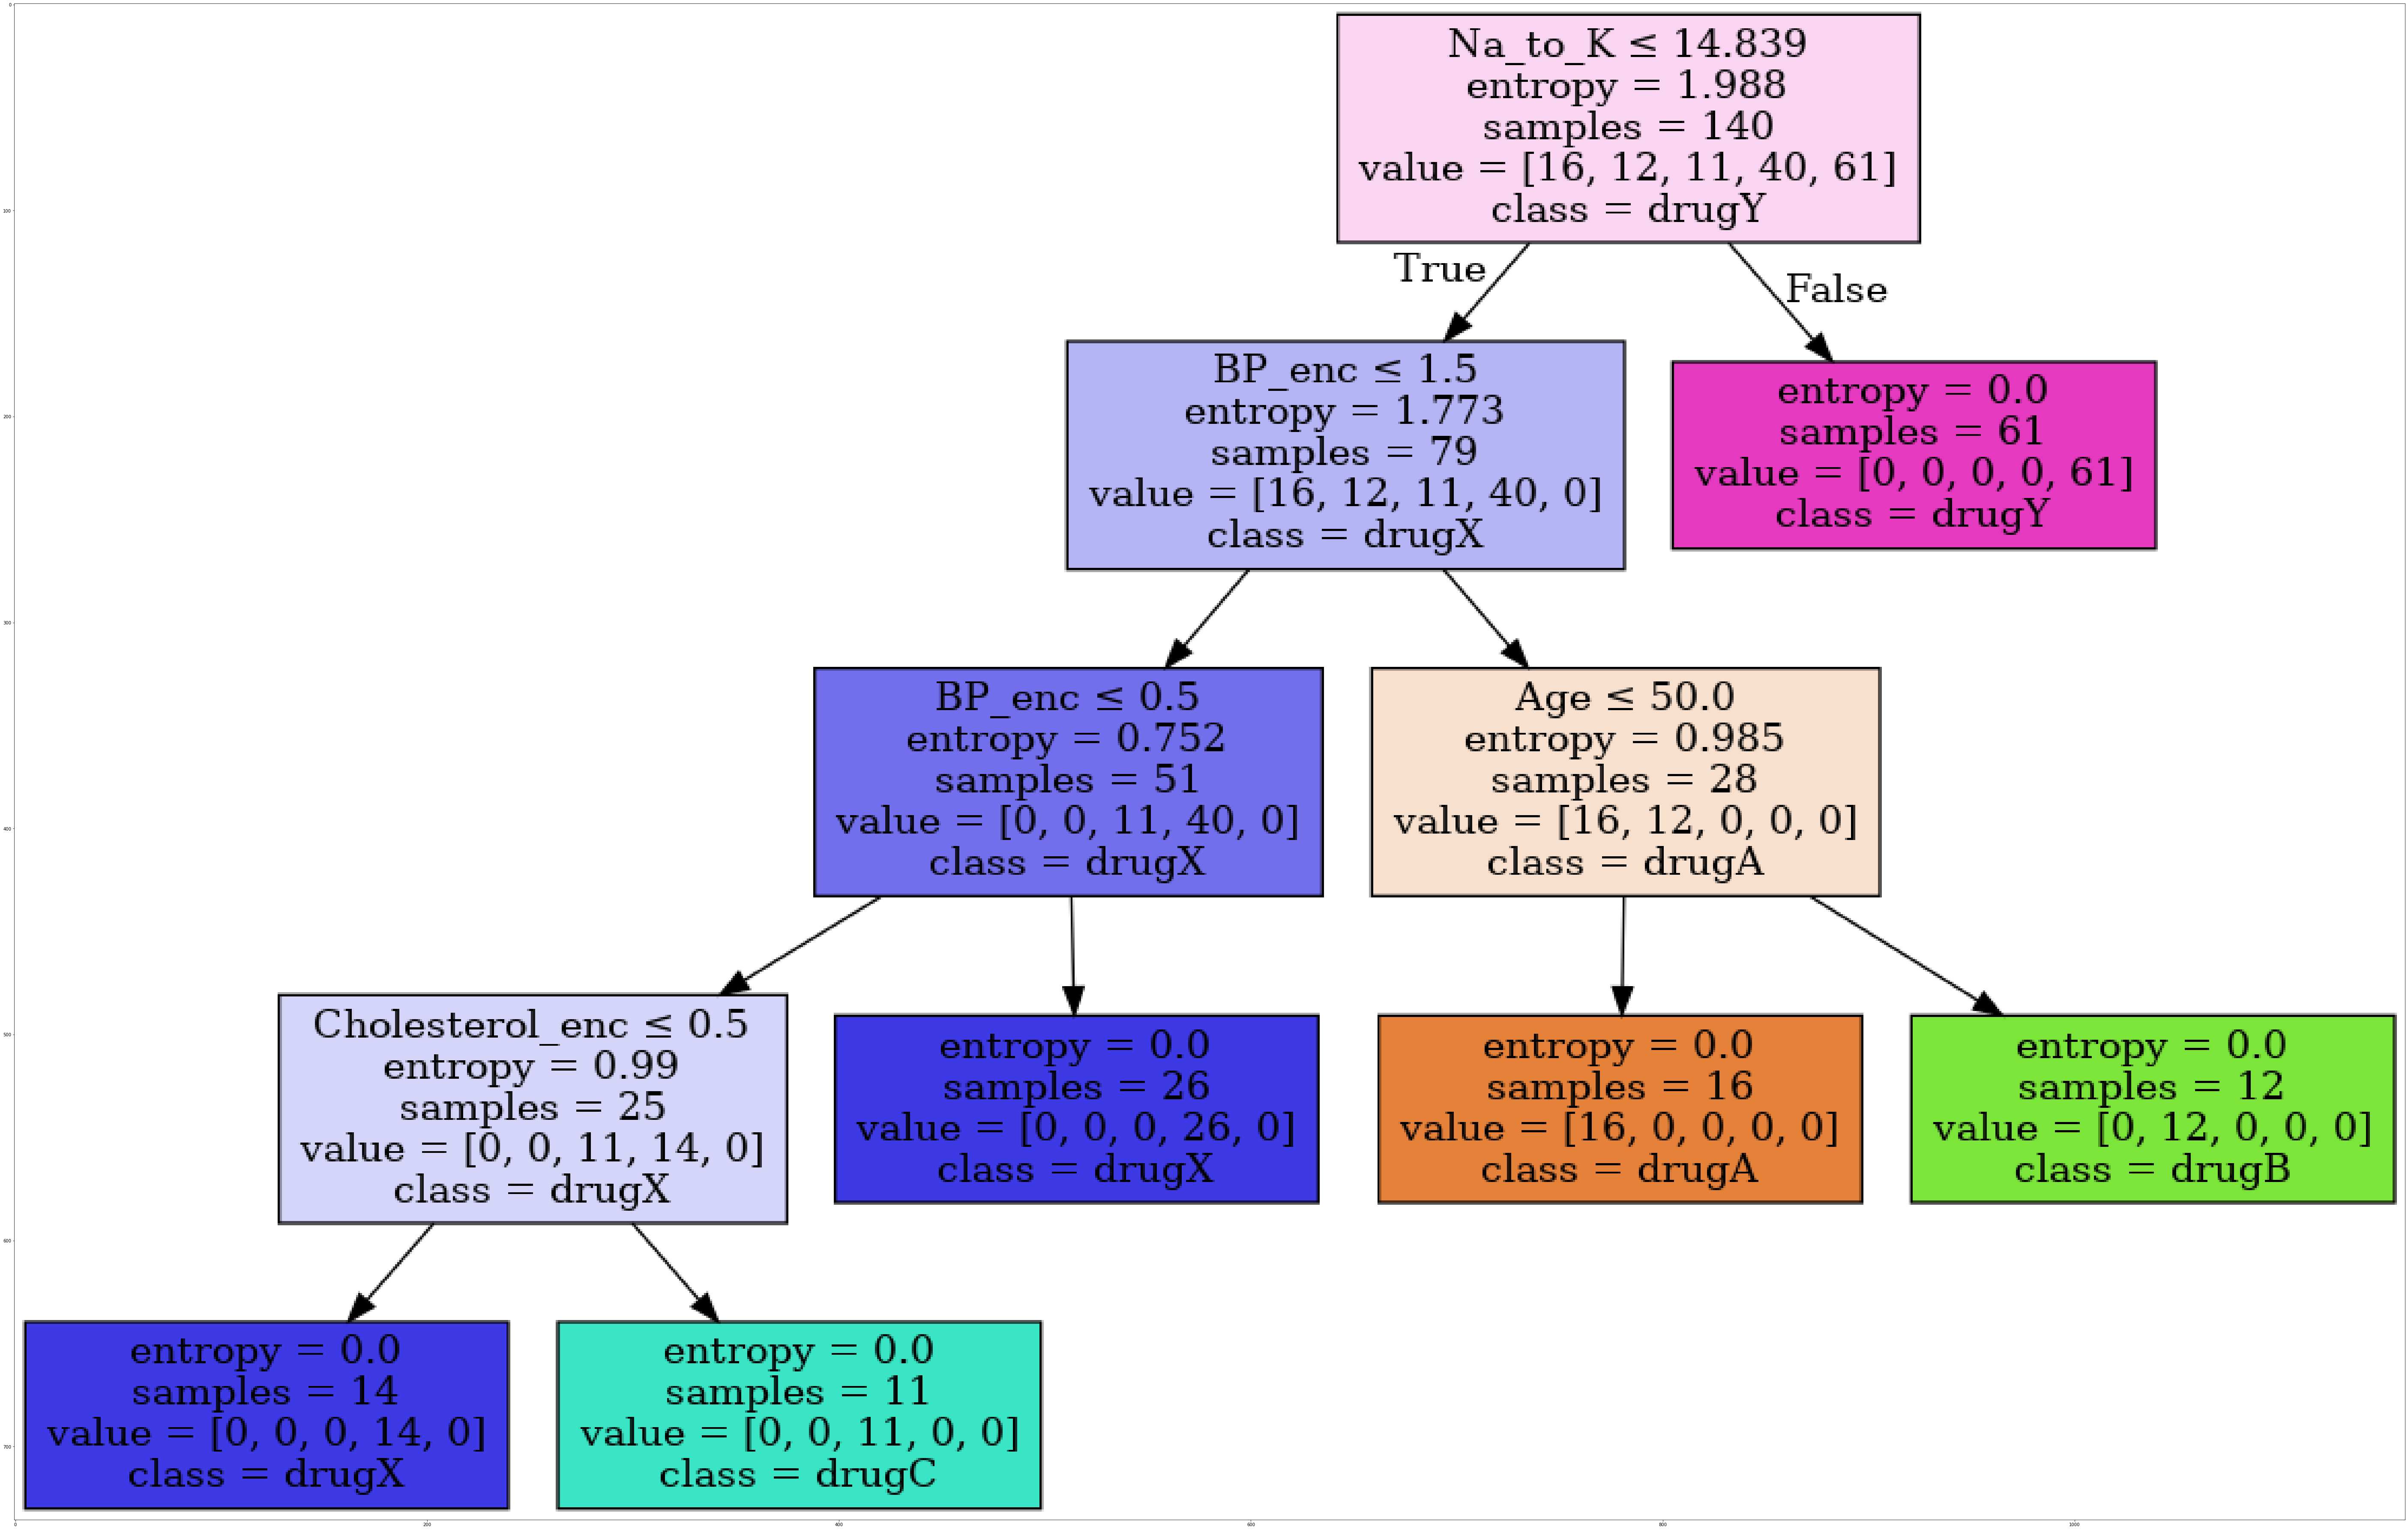

In [26]:
dot_data = StringIO()
filename = "tmp/model.png"
featureNames = X.columns
targetNames = df["Drug"].unique().tolist()
out=tree.export_graphviz(model,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')